In [1]:
from matplotlib.pylab import *
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from time import sleep 

π = pi


Biggest change(s) I have made from the other version of this notebook:

The model now accepts as an input separately the steering angle, as well as the state. 
Because of this, I have to take the state observation and steering angle as separate inputs, so they are stored in different tensors and collected separately. This was not the case in the original notebook. 

The motivation for this separation between the two is that as you will see in the controller training, the input to the emulator seems a little more apparent about how it is a nested input, which is propagated back in. 


Anohter minor addition is I used torchviz to visualize the computational graph, and confirm it does BPTT. 

In [2]:
style.use(['dark_background', 'bmh'])
%matplotlib notebook

Car-trailer diagram (inverted image `res/car-trainer-k.png` available as well):
![car-trailer](res/car-trailer-w.png)

Car-trailer equation:
\begin{align}
\dot x &= s \cos \theta_0 \\
\dot y &= s \sin \theta_0 \\
\dot \theta_0 &= \frac{s}{L} \tan \phi \\
\dot \theta_1 &= \frac{s}{d_1} \sin(\theta_1 - \theta_0)
\end{align}
where $s$: signed speed, $\phi$: negative steering angle,

In [3]:
class Truck:
    def __init__(self, display=False):

        self.W = 1  # car and trailer width, for drawing only
        self.L = 1 * self.W  # car length
        self.d = 4 * self.L  # d_1
        self.s = -0.1  # speed
        self.display = display
        
        self.box = [0, 40, -10, 10]
        if self.display:
            self.f = figure(figsize=(10, 5), num='The truck backer-upper', facecolor='none')
            self.ax = self.f.add_axes([0.01, 0.01, 0.98, 0.98], facecolor='black')
            self.patches = list()
            
            self.ax.axis('equal')
            b = self.box
            self.ax.axis([b[0] - 1, b[1], b[2], b[3]])
            self.ax.set_xticks([], []); self.ax.set_yticks([], [])
            self.ax.axhline(); self.ax.axvline()

        self.reset()
    
    def reset(self, ϕ=0):
        self.ϕ = ϕ  # car initial steering angle
        
        # self.θ0 = deg2rad(30)  # car initial direction
        # self.θ1 = deg2rad(-30)  # trailer initial direction
        # self.x, self.y = 20, -5  # initial car coordinates
        
        self.θ0 = random() * 2 * π  # 0 <= ϑ₀ < 2π
        self.θ1 = (random() - 0.5) * π / 2 + self.θ0  # -π/4 <= ϑ₁ - ϑ₀ < π/4
        self.x = (random() * .75 + 0.25) * self.box[1]
        self.y = (random() - 0.5) * (self.box[3] - self.box[2])
        
        # If poorly initialise, then re-initialise
        if not self.valid():
            self.reset(ϕ)
        
        # Draw, if display is True
        if self.display: self.draw()
    
    def step(self, ϕ=0, dt=1):
        
        # Check for illegal conditions
        if self.is_jackknifed():
            print('The truck is jackknifed!')
            return
        
        if self.is_offscreen():
            print('The car or trailer is off screen')
            return
        
        self.ϕ = ϕ
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        # Perform state update
        self.x += s * cos(θ0) * dt
        self.y += s * sin(θ0) * dt
        self.θ0 += s / L * tan(ϕ) * dt
        self.θ1 += s / d * sin(θ0 - θ1) * dt
        
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def state(self):
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def _get_atributes(self):
        return (
            self.x, self.y, self.W, self.L, self.d, self.s,
            self.θ0, self.θ1, self.ϕ
        )
    
    def _traler_xy(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return x - d * cos(θ1), y - d * sin(θ1)
        
    def is_jackknifed(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return abs(θ0 - θ1) * 180 / π > 90
    
    def is_offscreen(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        x1, y1 = x + 1.5 * L * cos(θ0), y + 1.5 * L * sin(θ0)
        x2, y2 = self._traler_xy()
        
        b = self.box
        return not (
            b[0] <= x1 <= b[1] and b[2] <= y1 <= b[3] and
            b[0] <= x2 <= b[1] and b[2] <= y2 <= b[3]
        )
        
    def valid(self):
        return not self.is_jackknifed() and not self.is_offscreen()
        
    def draw(self):
        if not self.display: return
        if self.patches: self.clear()
        self._draw_car()
        self._draw_trailer()
        self.f.canvas.draw()
            
    def clear(self):
        for p in self.patches:
            p.remove()
        self.patches = list()
        
    def _draw_car(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
        
        x1, y1 = x + L / 2 * cos(θ0), y + L / 2 * sin(θ0)
        bar = Line2D((x, x1), (y, y1), lw=5, color='C2', alpha=0.8)
        ax.add_line(bar)

        car = Rectangle(
            (x1, y1 - W / 2), L, W, 0, color='C2', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x1, y1, θ0 * 180 / π) +
            ax.transData
        )
        ax.add_patch(car)

        x2, y2 = x1 + L / 2 ** 0.5 * cos(θ0 + π / 4), y1 + L / 2 ** 0.5 * sin(θ0 + π / 4)
        left_wheel = Line2D(
            (x2 - L / 4 * cos(θ0 + ϕ), x2 + L / 4 * cos(θ0 + ϕ)),
            (y2 - L / 4 * sin(θ0 + ϕ), y2 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(left_wheel)

        x3, y3 = x1 + L / 2 ** 0.5 * cos(π / 4 - θ0), y1 - L / 2 ** 0.5 * sin(π / 4 - θ0)
        right_wheel = Line2D(
            (x3 - L / 4 * cos(θ0 + ϕ), x3 + L / 4 * cos(θ0 + ϕ)),
            (y3 - L / 4 * sin(θ0 + ϕ), y3 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(right_wheel)
        
        self.patches += [car, bar, left_wheel, right_wheel]
        
    def _draw_trailer(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
            
        x, y = x - d * cos(θ1), y - d * sin(θ1) - W / 2
        trailer = Rectangle(
            (x, y), d, W, 0, color='C0', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x, y + W/2, θ1 * 180 / π) +
            ax.transData
        )
        ax.add_patch(trailer)
        
        self.patches += [trailer]

<IPython.core.display.Javascript object>


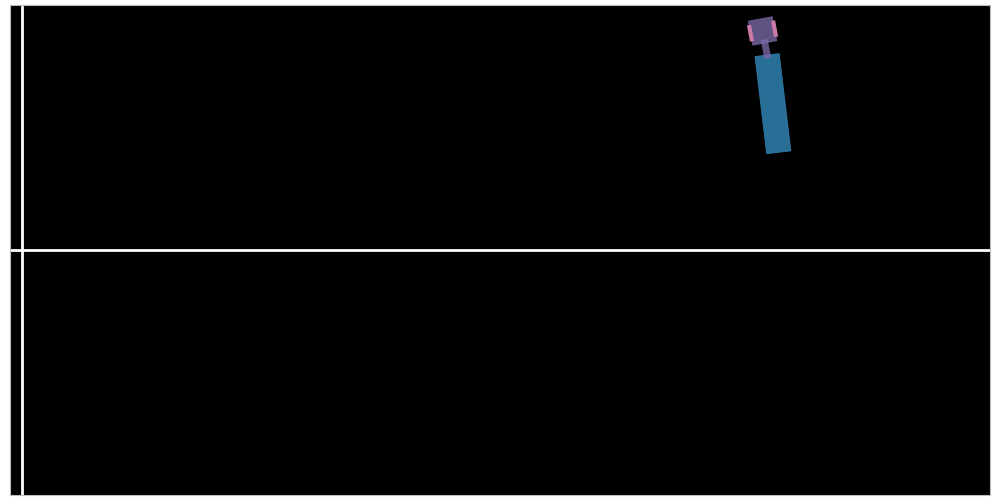

In [4]:
truck = Truck(display=True)

In [ ]:
ϕ = deg2rad(0)  # positive left, negative right
truck.step(ϕ)
truck.draw()

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import SGD,Adam
from tqdm import tqdm

In [6]:
# Build expert data set, 

#episodes = 10
angles = list()
states = list()
transitions = list()
truck = Truck(); 
episodes = 10_000  # uncomment for creating the data set

for episode in tqdm(range(episodes)):
    
    truck.reset()
    
    while truck.valid():
        initial_state = truck.state()
        ϕ = (random() - 0.5) * π / 2  
        angles.append([ϕ])
        states.append(initial_state)
        transitions.append(truck.step(ϕ))
        #truck.draw()

100%|██████████| 10000/10000 [00:24<00:00, 400.67it/s]


In [7]:
len(states), len(angles), len(transitions)

(598371, 598371, 598371)

In [8]:
#initialize emulator
state_size = 6
steering_size = 1
hidden_units_1 = 45
class Emulator(nn.Module):
    """
    emulator class so it is easier to understand, and allow gradient flow back to controller once in place. 
    """
    def __init__(self,state_size,steering_size,hidden_units_1): 
        super(Emulator, self).__init__()
        self.fc1 = nn.Linear(steering_size + state_size, hidden_units_1)
        self.fc2 = nn.Linear(hidden_units_1,state_size)
        
    def forward(self, steering_angle,observation):
        x = torch.cat([steering_angle,observation])
        x = F.relu(self.fc1(x))
        
        return self.fc2(x)
        
 
    

criterion = nn.MSELoss()
emulator = Emulator(6,1,45)
optimiser_e = SGD(emulator.parameters(), lr=0.005)


In [9]:
tensor_angles = torch.Tensor(angles)
tensor_states = torch.Tensor(states)
tensor_transitions = torch.Tensor(transitions)

In [10]:
#standardize 
mean = tensor_states.mean(0)
std = tensor_states.std(0)
tensor_inputs = (tensor_states - mean) / std
tensor_outputs = (tensor_transitions - mean) / std

In [11]:
# Split the data into 80:20 for test:train.
test_size = int(len(tensor_inputs) * 0.8)
print(len(tensor_inputs), test_size)

train_inputs = tensor_inputs[:test_size]
train_angles = tensor_angles[:test_size]
train_outputs = tensor_outputs[:test_size]


test_inputs = tensor_inputs[test_size:]
test_angles = tensor_angles[test_size:]
test_outputs = tensor_outputs[test_size:]

598371 478696


In [12]:
# Train:  regress on output state .. also only doing over 1 epoch, not really a great plan.
cnt = 0
for i in torch.randperm(len(train_inputs)):
    ϕ = train_angles[i]
    state = train_inputs[i]
    next_state_prediction = emulator(ϕ, state)
    
    next_state = train_outputs[i]
    loss = criterion(next_state_prediction, next_state) #regress
    
    optimiser_e.zero_grad()
    loss.backward()
    optimiser_e.step()
    
    if cnt == 0 or (cnt + 1) % 1000 == 0:
        print(f'{cnt + 1:4d} / {len(train_inputs)}, {loss.item():.10f}')
    cnt += 1

   1 / 478696, 1.2552937269
1000 / 478696, 0.0327757411
2000 / 478696, 0.0352335386
3000 / 478696, 0.0225077402
4000 / 478696, 0.0139226019
5000 / 478696, 0.0267774351
6000 / 478696, 0.0105704041
7000 / 478696, 0.0062178755
8000 / 478696, 0.0101191085
9000 / 478696, 0.0103124566
10000 / 478696, 0.0107984040
11000 / 478696, 0.0030897621
12000 / 478696, 0.0429678410
13000 / 478696, 0.0108923800
14000 / 478696, 0.0096977893
15000 / 478696, 0.0004288957
16000 / 478696, 0.0026398555
17000 / 478696, 0.0045832274
18000 / 478696, 0.0029165838
19000 / 478696, 0.0053622308
20000 / 478696, 0.0006733482
21000 / 478696, 0.0053462414
22000 / 478696, 0.0006670870
23000 / 478696, 0.0101080667
24000 / 478696, 0.0055553066
25000 / 478696, 0.0003551402
26000 / 478696, 0.0034132886
27000 / 478696, 0.0045131510
28000 / 478696, 0.0039851433
29000 / 478696, 0.0005843425
30000 / 478696, 0.0039938395
31000 / 478696, 0.0076160715
32000 / 478696, 0.0034079636
33000 / 478696, 0.0016423075
34000 / 478696, 0.004126

277000 / 478696, 0.0002230601
278000 / 478696, 0.0004275862
279000 / 478696, 0.0002065226
280000 / 478696, 0.0002047776
281000 / 478696, 0.0005497952
282000 / 478696, 0.0018196226
283000 / 478696, 0.0002868821
284000 / 478696, 0.0018247305
285000 / 478696, 0.0001240134
286000 / 478696, 0.0008628418
287000 / 478696, 0.0003617608
288000 / 478696, 0.0009303474
289000 / 478696, 0.0002011710
290000 / 478696, 0.0000626830
291000 / 478696, 0.0008343775
292000 / 478696, 0.0005397307
293000 / 478696, 0.0002704202
294000 / 478696, 0.0005671072
295000 / 478696, 0.0007179596
296000 / 478696, 0.0002302427
297000 / 478696, 0.0002143397
298000 / 478696, 0.0005871693
299000 / 478696, 0.0003873800
300000 / 478696, 0.0008363663
301000 / 478696, 0.0001211583
302000 / 478696, 0.0001816205
303000 / 478696, 0.0002724244
304000 / 478696, 0.0000702976
305000 / 478696, 0.0000843427
306000 / 478696, 0.0001311633
307000 / 478696, 0.0004399318
308000 / 478696, 0.0006946547
309000 / 478696, 0.0019355313
310000 / 4

In [13]:
# Test
total_loss = 0
with torch.no_grad():
    idx = -1
    for ϕ,state in zip(test_angles, test_inputs):
        idx +=1
        next_state_prediction = emulator(ϕ,state)

        next_state = test_outputs[idx]
        total_loss += criterion(next_state_prediction, next_state).item()

ave_test_loss = total_loss/test_size
print(f'Test loss: {ave_test_loss:.10f}')

Test loss: 0.0000436366


In [26]:
# Here you need to insert the code for training the controller
# by using the emulator for backpropagation

# If you succeed, feel free to send a PR

class Controller(nn.Module):
    """
    Controller class so it is easier to understand, and allow forward prop into emulator. e. 
    """
    def __init__(self,state_size,steering_size,hidden_units_1): 
        super(Controller, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_units_1)
        self.fc2 = nn.Linear(hidden_units_1,steering_size)        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = (torch.sigmoid(self.fc2(x))- 0.5) * π / 2 #squashed to correct domain
        return x

controller = Controller(state_size,steering_size,hidden_units_1=25)

optimiser_c = Adam(controller.parameters(), lr = 0.005)

# Controller Training

Forward Pass
1. Calculate the next steering signal with the controller
2. Use the actual truck to calculate the next position * == or use emulator! 
3. Repeat steps 1 and 2 until the truck is at the dock or a maximum number of steps $k$ were performed) 

Backward Pass

1. If the maximum number of steps was reached in step 3, do not perform backpropagation.
2. Calculate the sum squared error between the final truck position and the dock.
3. Calculate the derivative of the error wrt the truck state and use backpropagation through time (BPTT) to propagate the error through all emulators and controllers.
4. Update the weights of the controller

In [27]:
def offscreen_loss(ϕ_state,target_state):
    """
    Loss to backprop over if the terminal state was an outside one
    
    key difference between reinforcement learning and this type of control is you now have a differentiable loss. 
    
    Idea is to get as close to target state as possible, a straight truck touching the dock. 
    """
    
    return F.mse_loss(ϕ_state,target_state,reduction = 'sum')

def jackknife_loss(ϕ_state,target_state):
    """
    Loss to backprop over if terminal state is a jackknife
    
    Only computes MSE between the angle observations, a quick way to tell the truck it needs straighten out!
    """
    
    return F.mse_loss(ϕ_state[2::3],target_state[2::3],reduction = 'sum')


In [28]:
# Build controller data set

display=False #set to true if you want to see how training progresses. 

truck = Truck(display=display); 
episodes = 50_000  #creating the data set
target_state = torch.Tensor([4, 0, 0, 0, 0, 0]) #cab at 4, all else at 0. This is docking position. 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser_c, 'min', factor=0.85,   patience=1500, verbose=True)

Js = []
steps = []
controller.train()
emulator.train()
avg_loss = []
avg_steps = []
for episode in range(episodes):
    truck.reset()
    #in these commands below I give the problem an easier setup. From here, the truck only needs to back up
    #this slighlty angled position, and from there, prove it can ~learn. 
    truck.x = 9. 
    truck.y = 2.
    truck.θ0 = 0.
    truck.θ1 = 0.
    
    #standardize input 
    ϕ_state = torch.Tensor(truck.state())
    ϕ_state = (ϕ_state - mean) / std
    steps_ = 0
    while truck.valid(): # forward step 3
        #forward
        #start at initial, and go to the end 
        ϕ = controller(ϕ_state)
        ϕ_state  = emulator(ϕ,ϕ_state) #send grad through, but don't break.  
        true_state = truck.step(ϕ.item())
        if display: #draw how training goes
            truck.draw()
            sleep(.001)
        steps_ +=1
    ϕ_state = ϕ_state*std + mean
    loss = jackknife_loss(ϕ_state,target_state) + offscreen_loss(ϕ_state,target_state)
    
    optimiser_c.zero_grad() #set to zero
    loss.backward() #accumulate over entire graph
    optimiser_c.step()   

    Js.append(loss.item())
    steps.append(steps_)
    scheduler.step(loss)
    avg_loss.append( loss.item())
    avg_steps.append(steps_)
    if episode%1000 == 0:
        print("epoch: {}, avg_loss: {} avg_steps: {}".format(episode, np.mean(avg_loss), np.mean(avg_steps)))

        avg_loss = []
        avg_steps = []


epoch: 0, avg_loss: 3.596644401550293 avg_steps: 51.0
epoch: 1000, avg_loss: 6.367633140563965 avg_steps: 62.271
Epoch  1501: reducing learning rate of group 0 to 4.2500e-03.
epoch: 2000, avg_loss: 4.41519154214859 avg_steps: 58.074
epoch: 3000, avg_loss: 2.491150250196457 avg_steps: 54.7
epoch: 4000, avg_loss: 2.20456365776062 avg_steps: 54.0
epoch: 5000, avg_loss: 2.454031597971916 avg_steps: 54.031
Epoch  5482: reducing learning rate of group 0 to 3.6125e-03.
epoch: 6000, avg_loss: 2.195977138757706 avg_steps: 54.0
epoch: 7000, avg_loss: 2.229465993642807 avg_steps: 53.975
epoch: 8000, avg_loss: 2.2045611649751664 avg_steps: 53.954
Epoch  8160: reducing learning rate of group 0 to 3.0706e-03.
epoch: 9000, avg_loss: 2.2128674092292786 avg_steps: 54.003
epoch: 10000, avg_loss: 2.1924834539890288 avg_steps: 53.976
epoch: 11000, avg_loss: 2.113292236208916 avg_steps: 53.71
epoch: 12000, avg_loss: 1.966715486049652 avg_steps: 53.14
epoch: 13000, avg_loss: 1.9149307568073273 avg_steps: 53

KeyboardInterrupt: 

To view the truck in action, I preessed the power button on the plot above, re initialized, and watched it run from this spot. 

<IPython.core.display.Javascript object>


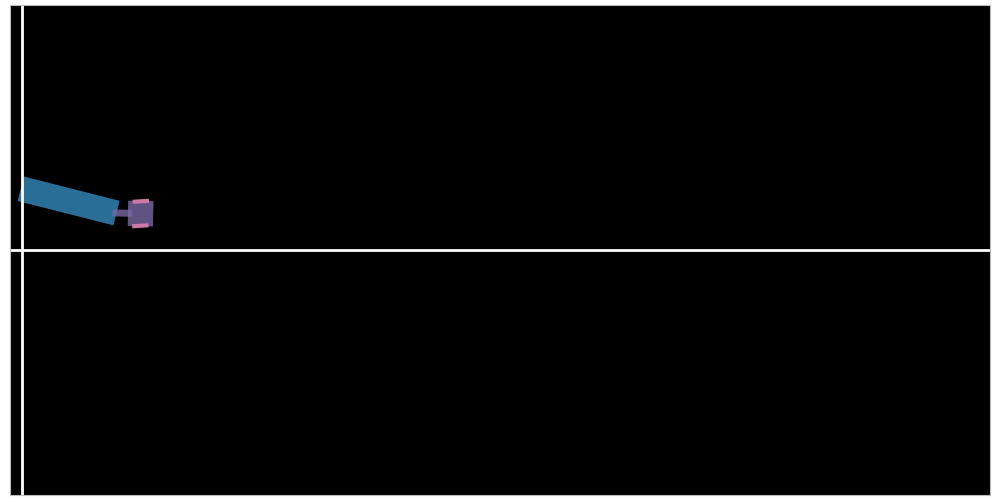

In [29]:
#Test controller:
from time import sleep 
%matplotlib notebook 
controller.eval()
truck = Truck(display=True); 


for i in range(10):
    truck.reset()
    truck.x = 9. 
    truck.y = 2.
    truck.θ0 = 0.
    truck.θ1 = 0.
    
    
    ϕ_state = torch.Tensor(truck.state())
    ϕ_state = (ϕ_state - mean) / std
    while truck.valid():
        ϕ = controller(ϕ_state)
        ϕ_state = truck.step(ϕ.item())
        ϕ_state = torch.Tensor(ϕ_state)

        ϕ_state = (ϕ_state - mean)/ std
        truck.draw()
        sleep(.001)

In [30]:
truck.state()

(3.830309560643493,
 1.5114238789413121,
 -0.022696409164116388,
 -0.04650592689201316,
 2.49646279979918,
 -0.24881923606865392)

From the above you see it gets \~modestly\~ close to [4,0,0,0,0]